# Run a multi-dimensional optimization

This page contains a very simple tutorial to optimize a multi-dimensional cost function.
Since problems with larger domains, such as multi-dimensional problems, will take many iterations of optimizers to search and find the minima, we will demonsrate how to execute these searches in parallel.

The key concepts you should gain from this page:

 * How to define a multi-dimensional cost function.
 * How to use an optimization search to find the minimum of the multi-dimensional cost function.
 * How to call the optimization in parallel.

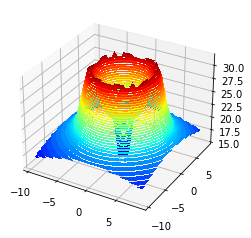

In [24]:
import matplotlib.pyplot as plt
import mystic
import numpy
from mystic import models
from scipy import stats

def cost_func(p):
    """ Executed for each set of drawn parameters in the optimization search.
    """
        
    # get the x and y values from Mystic
    # p is a list so we map each index of the list to our variables (x, y)
    x, y = p

    # get value at Gaussian function x and y
    var = stats.multivariate_normal(mean=[0, 0], cov=[[0.5, 0],[0, 0.5]])
    gauss = -50.0 * var.pdf([x, y])

    # get value at volcano function x and y
    r = numpy.sqrt(x**2 + y**2)
    mu, sigma = 5.0, 1.0
    stat = 25.0 * (numpy.exp(-r / 35.0) + 1.0 /
                   (sigma * numpy.sqrt(2.0 * numpy.pi)) *
                    numpy.exp(-0.5 * ((r - mu) / sigma) ** 2)) + gauss

    # whether to flip sign of function
    # a positive lets you search for minimum
    # a negative lets you search for maximum
    stat *= 1.0

    return stat

mystic.model_plotter(cost_func, depth=True, fill=True, bounds='-9.5:9.5,-9.5:9.5')

## Run an opitimizer

We can run a single optimizer with the multi-dimensional cost function like we did before.
Below we set the **initial points**, **strict ranges**, and **termination condition** for a solver to find the minimum.

In [28]:
from mystic import tools
from mystic.solvers import PowellDirectionalSolver
from mystic.ensemble import BuckshotSolver
from mystic.termination import VTR

# set random seed so we can reproduce results
tools.random_seed(0)

# create a solver
solver = PowellDirectionalSolver(2)

# set the initial position to (0, 0)
solver.SetInitialPoints([0, 0])

# set the range to search for both parameters between -9.5 and 9.5
solver.SetStrictRanges((-9.5, -9.5), (9.5, 9.5))

# find the minimum
# pass the termination condition
solver.Solve(cost_func, VTR())

# print the best parameters
print(f"The best solution is {solver.bestSolution}")

The best solution is [-2.24303552e-02  9.64325450e-07]


## Run a optimization search

In the prior examples, we only ran a single optimizer and found a nearby local minimum.
However, we can use an ensemble of optimizers to map the surface.
For example, by running a set of optimizers we should be able to recreate the surface of the volcano function at the top of this page.
Below, we show how to execute an optimization search using the ``BuckshotSolver``.

In [37]:
from mystic import tools
from mystic.solvers import PowellDirectionalSolver
from mystic.ensemble import BuckshotSolver
from mystic.termination import VTR

# set random seed so we can reproduce results
tools.random_seed(0)

# create a solver
solver = BuckshotSolver(2, 8)

# since we have an search solver
# we specify what optimization algorithm to use within the search
solver.SetNestedSolver(PowellDirectionalSolver)

# set the range to search for both parameters between -9.5 and 9.5
solver.SetStrictRanges((-9.5, -9.5), (9.5, 9.5))

# find the minimum
# pass the termination condition
solver.Solve(cost_func, VTR())

# print the best parameters
print(f"The best solution is {solver.bestSolution}")

The best solution is [-3.16087505e-05 -2.24303335e-02]


The solver stores a list of the prior results.
We can plot the results as follows.

/var/folders/7b/9dh6yr6n6d9dvwlc33g1_3rw0000gp/T/ipykernel_20437/3378301345.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = figure.gca(**kwds)


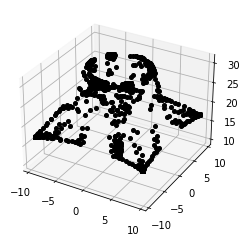

In [47]:
from mystic import cache
from mystic.math import interpolate
from mystic.samplers import LatticeSampler

model = cache.cached(archive="volcano")(cost_func)

# sample initial points from a Uniform distribution, then search for minima 
sampler = LatticeSampler([(-9.5, 9.5), (-9.5, 9.5)], model, 16)
sampler.sample_until(terminated=all)

# invert the model
imodel = model.__inverse__

# sample initial points from a Uniform distribution, then search for maxima 
isampler = LatticeSampler([(-9.5, 9.5), (-9.5, 9.5)], imodel, 16)
isampler.sample_until(terminated=all)

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import mystic.cache as mc

figure = plt.figure()
kwds = {'projection':'3d'}
ax = figure.gca(**kwds)
ax.autoscale(tight=True)

# read the archive used above, and show the sampled points
c = mc.archive.read('volcano')
x, y = np.array(list(c.keys())), np.array(list(c.values()))
ax.plot(x.T[0], x.T[1], y, 'ko', linewidth=2, markersize=4)
plt.show()


## Multi-processing with an optimization search
That took awhile, we can run things in parallel.
Let's cut the execution time by using multi-processing.
Running the command below, you should see it took a shorter time to complete.

In [48]:
from pathos.pools import ProcessPool as Pool

# set random seed so we can reproduce results
tools.random_seed(0)

# create a solver
solver = BuckshotSolver(2, 8)

# since we have an search solver
# we specify what optimization algorithm to use within the search
solver.SetNestedSolver(PowellDirectionalSolver)

# set multi-processing
solver.SetMapper(Pool().map)

# set the range to search for both parameters between -9.5 and 9.5
solver.SetStrictRanges((-9.5, -9.5), (9.5, 9.5))

# find the minimum
# pass the termination condition
solver.Solve(cost_func, VTR())

# print the best parameters
print(f"The best solution is {solver.bestSolution}")

The best solution is [-3.16087505e-05 -2.24303335e-02]


You should now have an understanding of how to setup a optimization search and execute it in parallel. We will now move on to how this can be implemented in a Rietveld analysis.